# Time Series Methods Demo

In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from SpatialScan.preprocessing import *
from SpatialScan.synthetic import *
from SpatialScan.timeseriesjam import *
from SpatialScan.timeseries import *
import time

In [4]:
df = pd.read_csv('jamcam2.csv', index_col=False, parse_dates=[4, 5])

In [5]:
df["n_vehicles_in_interval"]=df["n_vehicles_in_interval"].astype(float)

In [6]:
DF=jam_preprocessor(df, max_anom = 5, N_sigma = 3, repeats = 2, percentage_missing=15)

Using the 16-day rolling median to remove outliers ...
Using 2 iterations to remove points outside of 3 sigma from the rolling median ...
Calculating threshold(s): Iteration 2 of 2...
Threshold(s) calculated.

Dropping detectors with more than 5 anomalies...
Dropping detectors with sufficiently high amounts of missing data (>15%)...
1 detectors dropped: {1.07313}



1.06692


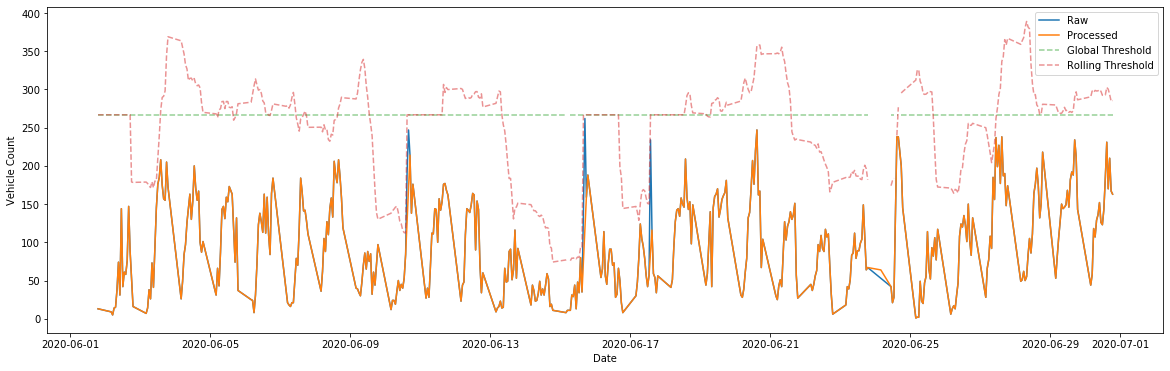

In [7]:
plot_processing(df, DF)

In [9]:
detectors=DF["detector_id"].unique()

In [10]:
hours_since_start=(DF["measurement_end_utc"]-DF["measurement_end_utc"].min()).astype("timedelta64[h]").to_numpy()

In [11]:
hours_since_start

array([  0.,   9.,  10., ..., 694., 695., 696.])

## Holt-Winters
The multiplicative Holt–Winters’ (HW) method is a more dynamic forecasting method that takes into account smaller periodic trends, as well as long term trends (such as seasonal trends). It has three main components: the smoothed value $S_t$ , trend component $Tt$ , and the periodic component $I_t$

### $
S_{t}=\alpha \frac{c_{i}^{t}}{I_{t+16}}+(1-\alpha)\left(S_{t+1}+T_{t+1}\right) \\
T_{t}=\beta\left(S_{t}-S_{t+1}\right)+(1-\beta) T_{t+1} \\
I_{t}=\gamma \frac{c_{i}^{t}}{S_{t}}+(1-\gamma) I_{t+16}$

These are iterated through historical data, and then extended to the forecasting period, where the baseline estimate for the next hour is then given by $b^t_i=\left(S_{t+1}+T_{t+1}\right) I_{t+24}$. the baseline is then replaced for count in the equations above, and iterated across the forecasting period.

Strengths: Very quick, simple

Weaknesses: Over simplistic, does not give uncertainty estimates, does not extend well to longer forecasts

In [12]:
CB_HW=count_baselineJ(DF, 20, 3, alpha = 0.02, beta = 0.02, gamma = 0.4)

Input dataframe contains data spanning 2020-06-01 18:00:00 to 2020-06-30 19:00:00.
Using data from 2020-06-01 18:00:00 to 2020-06-27 19:00:00, to forecast counts between 2020-06-27 19:00:00 and 2020-06-30 19:00:00 for 22 detectors using HW method...
Forecasting complete.


1.06697


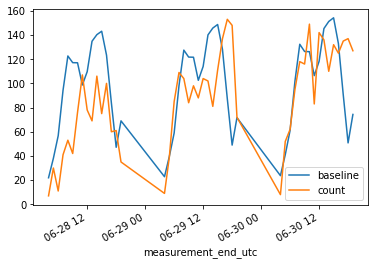

In [13]:
forecast_plotJ(CB_HW)

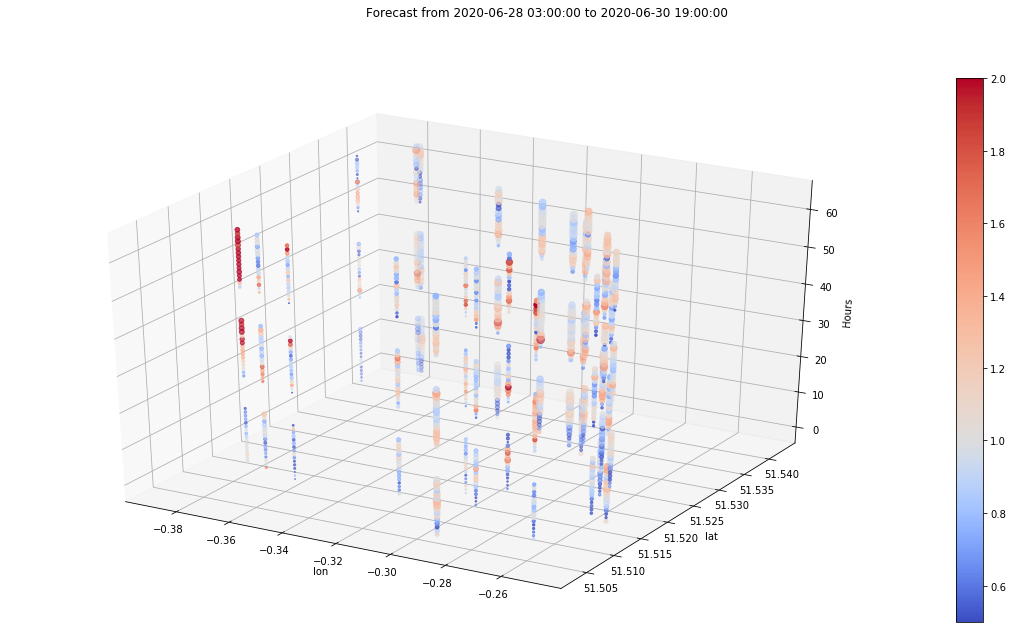

In [14]:
CB_plotJ(CB_HW)

## Gaussian Process
for the sake of our GP modelling we shall consider two kernels: the standard squared exponential kernel $k_{\mathrm{SE}}$ and the periodic kernel $k_{\mathrm{P}}$, given below.
        
#### $
k_{\mathrm{SE}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2} \frac{\left(x_{d}-x_{d}^{\prime}\right)^{2}}{l}\right)$

#### $
k_{\mathrm{P}}\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\alpha^{2} \exp \left(-\frac{1}{2}\left(\frac{\sin \left(\tau\left(x_{d}-x_{d}^{\prime}\right)\right)}{l}\right)^{2}\right) 
$

for the periodic elements likely from traffic forecasts, we need the periodic kernel. Considering the patterns associated with traffic forecast, we suggest a tailored kernel composed of the sum of three kernels:

$k_1(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 16 hours to capture the daily periodic patterns 
    
$k_2(x, x^\prime)$ a periodic kernel with a periodicity hyper-parameter equal to 16 $\times$ 7 hours to capture the day-of-the-week periodicity
    
$k_3(x, x^\prime)$ a squared exponential kernel for deviations and underlying trends

Our tailored kernel will be using a combination of these three, $k(x, x^\prime) = k_1(x, x^\prime) \times k_2(x, x^\prime) + k_3(x, x^\prime)$, thus leaving six hyper-parameters to fine tune, three variances and three length scales. These are optimised using GPflows optimisation module

In [15]:
CB_GP=count_baselineJ(DF, 17, 3, method="GP")

Input dataframe contains data spanning 2020-06-01 18:00:00 to 2020-06-30 19:00:00.
Using data from 2020-06-01 18:00:00 to 2020-06-27 19:00:00, to forecast counts between 2020-06-27 19:00:00 and 2020-06-30 19:00:00 for 22 detectors using GP method...
Forecasting complete.


1.08


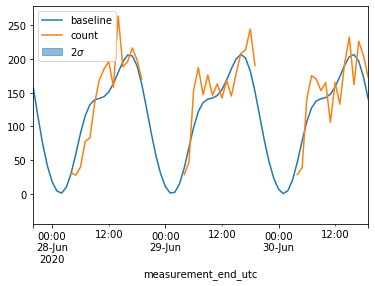

In [20]:
forecast_plotJ(CB_GP)

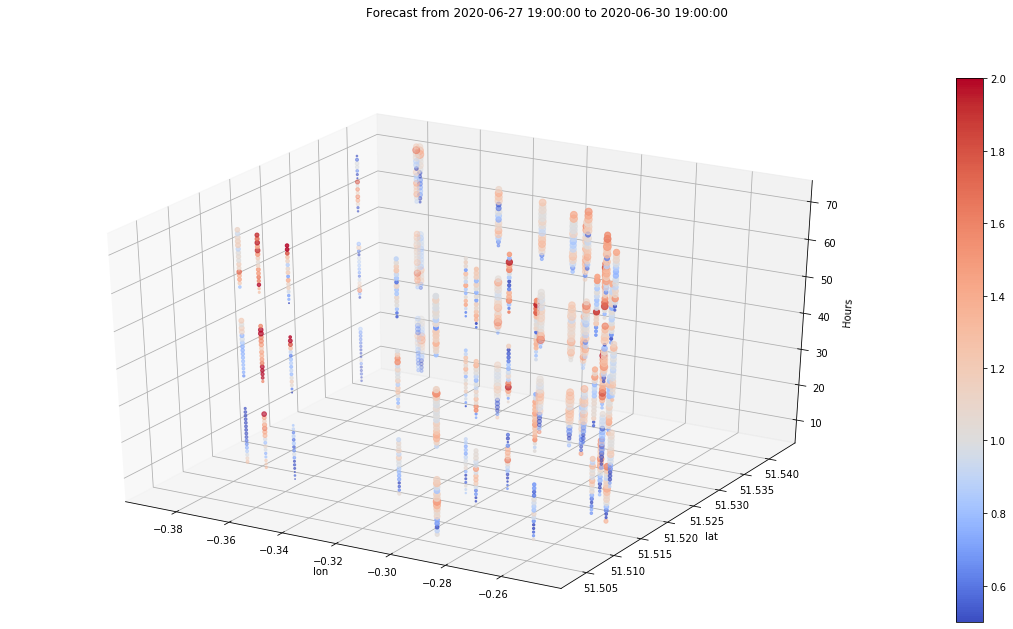

In [21]:
CB_plotJ(CB_GP)

In [14]:
def GP_forecast2(
    df: pd.DataFrame,
    days_in_past: int = 2,
    days_in_future: int = 1,
    detectors: list = None,
) -> pd.DataFrame:

    """Forecast using Gaussian Processes 
    Args: 
        df: Dataframe of JamCam data
        days_in_past: Integer number of previous days to use for forecast
        days_in_future: Days in future produce a for forecast for
        detectors: List of detectors to look at


    Returns:
        Dataframe forecast in same format as JamCam input dataframe

        """

    # extract numpy array of detector ID's
    if detectors is None:
        detectors = df["detector_id"].drop_duplicates().to_numpy()
    framelist = []

    i = 0
    for detector in detectors:
        i += 1

        dataset = df[df["detector_id"] == detector].tail(n=26* days_in_past)

        Y = dataset["n_vehicles_in_interval"].to_numpy().reshape(-1, 1)
        Y = Y.astype(float)
        X = (dataset["measurement_end_utc"]-dataset["measurement_end_utc"].min()).astype("timedelta64[h]").to_numpy().reshape(-1, 1)

        scaler = MinMaxScaler(feature_range=(-1, 1))
        y = scaler.fit_transform(Y)

        kern_pD = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
        kern_pW = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
        kern_SE = gpflow.kernels.SquaredExponential()
        kern_W = gpflow.kernels.White()
        # kern_M = gpflow.kernels.Matern52()

        kern_pD.period.assign(24.0)
        # kern_pD.base_kernel.variance.assign(10)
        kern_pW.period.assign(168.0)
        # kern_pW.base_kernel.variance.assign(10)

        k = kern_pD * kern_pW + kern_SE + kern_W

        m = gpflow.models.GPR(data=(X, y), kernel=k, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(
            m.training_loss, m.trainable_variables, options=dict(maxiter=100)
        )

        print("please wait: ", i, "/", len(detectors), end="\r")

        ## generate test points for prediction
        xx = np.linspace(
            X.max() + 1, X.max() + (days_in_future * 24) + 1, (days_in_future * 24)
        ).reshape(
            (days_in_future * 24), 1
        )  # test points must be of shape (N, D)

        ## predict mean and variance of latent GP at test points
        mean, var = m.predict_f(xx)

        # reverse min_max scaler
        testPredict = scaler.inverse_transform(mean)
        testVar = scaler.inverse_transform(var)

        # find the time period for our testPredictions
        start_date = dataset["measurement_end_utc"].max()
        end_date = start_date + np.timedelta64(24 * (days_in_future) -1, "h")

        T = pd.date_range(start_date, end_date, freq="H")

        # organise data into dataframe similar to the SCOOT outputs
        df2 = pd.DataFrame(
            {
                "detector_id": detector,
                "lon": df[df["detector_id"] == detector]["lon"].iloc[0],
                "lat": df[df["detector_id"] == detector]["lat"].iloc[0],
                "measurement_start_utc": T,
                "measurement_end_utc": T + np.timedelta64(1, "h"),
                "n_vehicles_in_interval": testPredict.flatten(),
                "prediction_variance": testVar.flatten(),
            }
        )

        framelist.append(df2)

    return pd.concat(framelist)

In [149]:
days_in_past=20
days_in_future=2

dataset = df[df["detector_id"] == detectors[0]].tail(n=26* days_in_past)

Y = dataset["n_vehicles_in_interval"].to_numpy().reshape(-1, 1)
Y = Y.astype(float)
X = (dataset["measurement_end_utc"]-dataset["measurement_end_utc"].min()).astype("timedelta64[h]").to_numpy().reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(Y)

kern_pD = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
kern_pW = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential())
kern_SE = gpflow.kernels.SquaredExponential()
kern_W = gpflow.kernels.White()
# kern_M = gpflow.kernels.Matern52()

kern_pD.period.assign(24.0)
# kern_pD.base_kernel.variance.assign(10)
kern_pW.period.assign(168.0)
# kern_pW.base_kernel.variance.assign(10)

k = kern_pD * kern_pW + kern_SE




In [150]:
m = gpflow.models.GPR(data=(X, y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
## generate test points for prediction
xx = np.linspace(
   10, X.max() + (days_in_future * 24) + 1, (days_in_future * 24)
).reshape(
    (days_in_future * 24), 1
)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)




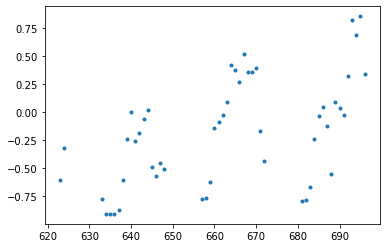

In [151]:
plt.plot(X[-50:], y[-50:], ".")

In [7]:
gp=GP_forecast2(DF, 18, 1)

In [8]:
gp_d

NameError: name 'gp_d' is not defined

In [37]:
d=0
gp_d=gp[gp["detector_id"]==detectors[5]]
test_d=test_data[test_data["detector_id"]==detectors[5]]

In [43]:
y=GP_forecast2(train_data, 18, 1)

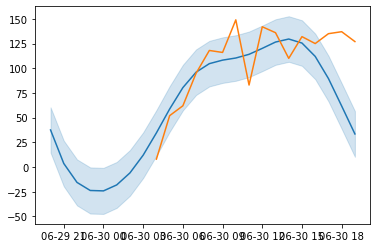

In [38]:
plt.plot(gp_d["measurement_end_utc"],gp_d["n_vehicles_in_interval"])
plt.fill_between(
    gp_d["measurement_end_utc"],
    gp_d["n_vehicles_in_interval"] - 1.96 * np.sqrt(gp_d["prediction_variance"]),
    gp_d["n_vehicles_in_interval"] + 1.96 * np.sqrt(gp_d["prediction_variance"]),
    color="C0",
    alpha=0.2,
)
plt.plot(test_d["measurement_end_utc"],test_d["n_vehicles_in_interval"])
#fig, ax = plt.subplots()

In [40]:
sd=[]
for detector in detectors:

    sd.append(test_data[test_data["detector_id"] == detector])

    sample_test_data = pd.concat(sd)

In [42]:
sample_test_data

,detector_id,measurement_end_utc,detection_class,lon,lat,borough_name,n_vehicles_in_interval,measurement_start_utc,rolling_threshold,global_threshold,Num_Anom,Num_Missing
449,1.06683,2020-06-30 04:00:00,car,-0.26051,51.5064,Ealing,71.0,2020-06-30 03:00:00,422.411618,356.765489,1.0,11
450,1.06683,2020-06-30 05:00:00,car,-0.26051,51.5064,Ealing,72.0,2020-06-30 04:00:00,423.442567,356.765489,1.0,11
451,1.06683,2020-06-30 06:00:00,car,-0.26051,51.5064,Ealing,92.0,2020-06-30 05:00:00,425.403615,356.765489,1.0,11
452,1.06683,2020-06-30 07:00:00,car,-0.26051,51.5064,Ealing,161.0,2020-06-30 06:00:00,426.674055,356.765489,1.0,11
453,1.06683,2020-06-30 08:00:00,car,-0.26051,51.5064,Ealing,195.0,2020-06-30 07:00:00,426.522171,356.765489,1.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
10225,1.08010,2020-06-30 15:00:00,car,-0.28891,51.5033,Ealing,417.0,2020-06-30 14:00:00,656.171307,646.096205,0.0,9
10226,1.08010,2020-06-30 16:00:00,car,-0.28891,51.5033,Ealing,386.0,2020-06-30 15:00:00,654.512710,646.096205,0.0,9
10227,1.08010,2020-06-30 17:00:00,car,-0.28891,51.5033,Ealing,378.0,2020-06-30 16:00:00,641.255014,646.096205,0.0,9
10228,1.08010,2020-06-30 18:00:00,car,-0.28891,51.5033,Ealing,402.0,2020-06-30 17:00:00,587.057553,646.096205,0.0,9


In [46]:
Y = y.merge(
    sample_test_data,
    on=[
        "lon",
        "lat",
        "measurement_end_utc",
        "detector_id",
        "measurement_start_utc",
    ],
    how="left",
)
Y = Y.rename(
        columns={
            "n_vehicles_in_interval_x": "baseline",
            "n_vehicles_in_interval_y": "count",
        }
    )

1.08


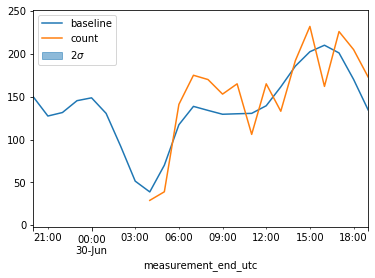

In [56]:
forecast_plot(Y)